## Import libraries

In [3]:
import numpy as np
from numpy import sqrt, argmax
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

import syft as sy

# import opacus
# from opacus import PrivacyEngine

import warnings
from pprint import pprint
warnings.filterwarnings("ignore")

import pandas as pd
import re
from nltk.corpus import stopwords

# from syft.frameworks.torch.nn import GRU
from handcrafted_GRU import GRU
# from opacus.layers import DPGRU

from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device:{device}")

print(f"Torch Ver: {torch.__version__}")
# print(f"Opacus Ver: {opacus.__version__}")
# print(f"Syft Ver: {sy.__version__}")


Device:cuda
Torch Ver: 1.4.0


In [37]:
STOPWORDS = set(stopwords.words('indonesian'))
# print(f"STOPWORDS:\n {STOPWORDS}")

def clean_text(text):
    # print(f"\n\nOriginal Text: {text}")
    text = text.lower()
    # print(f"\nCase Lowered Text: {text}")
    text = re.sub(r'[^a-z\s]', '', text)
    # print(f"\nRegexed Text: {text}")
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    # print(f"\nStopwords Removed Text: {text}")
    return text

def tokenize(text, word_to_idx):
    tokens = []
    for word in text.split():
        if word in word_to_idx:
            tokens.append(word_to_idx[word])
        else:
            tokens.append(0)
    return tokens

def pad_and_truncate(messages, max_length=30):
    features = np.zeros((len(messages), max_length), dtype=int)
    # pprint(f"Messages: {messages}\nFeatures: {features}")
    for i, sms in enumerate(messages):
        # print(f"\ni: {i}\nSMS:{sms}")
        if len(sms):
            features[i, -len(sms):] = sms[:max_length]
    return features

In [89]:
if __name__ == '__main__':
    data = pd.read_csv('train_sms_1240.csv', sep=',', names=['Teks', 'Label'], encoding= 'unicode_escape')
    # data = data.sample(frac = 1)
    # Lowercase, remove unnecessary char with regex, remove stop words
    data.Teks = data.Teks.apply(clean_text)
    # print(data.Teks)
    words = set((' '.join(data.Teks)).split())
    # print(words)
    word_to_idx = {word: i for i, word in enumerate(words, start=1)}
    # print(word_to_idx)
    tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
    # print(tokens)
    inputs = pad_and_truncate(tokens)
    # pprint(inputs)
    labels = np.array((data.Label == '1').astype(int))

    np.save('labels.npy', labels)
    np.save('inputs.npy', inputs)

('Messages: 0                           [3454, 2763, 2128, 761, 1621]\n'
 '1       [1043, 3719, 3504, 1572, 367, 3096, 3298, 2085...\n'
 '2       [1016, 4103, 1722, 3148, 3916, 3029, 3570, 451...\n'
 '3       [851, 1146, 2059, 4116, 3284, 2784, 1574, 1146...\n'
 '4       [933, 1296, 2982, 281, 4234, 3757, 3425, 176, ...\n'
 '                              ...                        \n'
 '1235    [4120, 3952, 3157, 428, 1425, 3032, 3607, 2732...\n'
 '1236            [3454, 1120, 2501, 1816, 2483, 1816, 412]\n'
 '1237    [1016, 1638, 2389, 2488, 2472, 1161, 1109, 286...\n'
 '1238                                    [3453, 995, 1620]\n'
 '1239        [706, 2657, 1520, 706, 2206, 251, 2657, 2967]\n'
 'Name: Teks, Length: 1240, dtype: object\n'
 'Features: [[0 0 0 ... 0 0 0]\n'
 ' [0 0 0 ... 0 0 0]\n'
 ' [0 0 0 ... 0 0 0]\n'
 ' ...\n'
 ' [0 0 0 ... 0 0 0]\n'
 ' [0 0 0 ... 0 0 0]\n'
 ' [0 0 0 ... 0 0 0]]')


## Training model with Federated learning

### Training and model hyperparameters

In [4]:
# Training params
TRAIN_VOCAB_SIZE = int(inputs.max()) + 1
EPOCHS = 200
CLIP = 5 # gradient clipping - to avoid gradient explosion (frequent in RNNs)
lr = 0.001
BATCH_SIZE = 30

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

### Train and Test Split

In [5]:
original_inputs = np.load('inputs.npy')
original_labels = np.load('labels.npy')

inputs = torch.tensor(original_inputs)
labels = torch.tensor(original_labels)

# splitting training and test data
# 20% of the data will be for Tests.
pct_test = 0.2

#20% of total data
pct_test_count = -int(len(labels)*pct_test)

# Get 80% of Train LABELS from left.
train_labels = labels[:pct_test_count]
print(f"Train Labels: [:{pct_test_count}]")

# Get 80% of Train INPUTS from left.
train_inputs = inputs[:pct_test_count]
print(f"Train Inputs: [:{pct_test_count}]")

# Get the rest of the LABEL data for test on the right (20%) 
test_labels = labels[pct_test_count:]
print(f"Test Labels: [{pct_test_count}:]")

# Get the rest of the INPUT data for test on the right (20%)
test_inputs = inputs[pct_test_count:]
print(f"Test Inputs: [{pct_test_count}:]")


SAMPLE_SIZE = len(labels)
print(f"Sample Size: {SAMPLE_SIZE}")

print(f"20% of Sample Size: {SAMPLE_SIZE*pct_test}")

# For Local Model Evaluation
original_test_inputs = original_inputs[pct_test_count:]
original_test_labels = original_labels[pct_test_count:]

### VirtualWorkers

In [6]:
# Hook that extends the Pytorch library 
# to enable all computations with pointers of tensors sent to other workers
hook = sy.TorchHook(torch)

# Creating 2 virtual workers Syft v0.2.9
anne = sy.VirtualWorker(hook, id="anne")
bob = sy.VirtualWorker(hook, id="bob")

workers = [anne, bob]

# this is done to have the local worker (you on your notebook!) have a registry
# of objects like every other workers, which is disabled by default but needed here
# sy.local_worker.is_client_worker = False


# threshold indexes for dataset split (one half for Bob, other half for Anne)
train_idx = int(len(train_labels)/2)
test_idx = int(len(test_labels)/2)

# Sending toy datasets to virtual workers
bob_train_dataset = sy.BaseDataset(train_inputs[:train_idx], train_labels[:train_idx]).send(bob)
anne_train_dataset = sy.BaseDataset(train_inputs[train_idx:], train_labels[train_idx:]).send(anne)
bob_test_dataset = sy.BaseDataset(test_inputs[:test_idx], test_labels[:test_idx]).send(bob)
anne_test_dataset = sy.BaseDataset(test_inputs[test_idx:], test_labels[test_idx:]).send(anne)

# print(f"Train Index: {train_idx}")
# print(f"Test Index: {test_idx}")

# print(f"Anne's Data Amount: {len(train_inputs[train_idx:])}")
# print(f"Bob's Data Amount: {len(train_inputs[:train_idx])}")


# Creating federated datasets, an extension of Pytorch TensorDataset class 
# for TRAINING METHOD #1 (with aggregation)
bob_federated_train_dataset = sy.FederatedDataset([bob_train_dataset])
anne_federated_train_dataset = sy.FederatedDataset([anne_train_dataset])
bob_federated_test_dataset = sy.FederatedDataset([bob_test_dataset])
anne_federated_test_dataset = sy.FederatedDataset([anne_test_dataset])


merged_test_dataset = list(zip(original_test_inputs, original_test_labels))

# print(f"Input:{original_test_inputs[1]}\t Label:{original_test_labels[1]}")
# print(merged_test_dataset[0])

def collate_batch(batch):
        label_list, text_list = [], []
        for (_label, _text) in batch:
                label_list.append(_label)
                text_list.append(_text)
        return label_list, text_list

original_test_dataloader = DataLoader(merged_test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

### Import GRU Model

In [7]:
# Initiating the model
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
# model = GRU(vocab_size=TRAIN_VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
# torch.set_default_tensor_type('torch.FloatTensor')

def make_model():
    model = GRU(vocab_size=TRAIN_VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
    return model
    
local_model = make_model()

models, train_dataloaders, test_dataloaders, optimizers, privacy_engines = [], [], [], [], []

### Attaching model, dataloaders, and optimizers to each worker

In [8]:
for worker in workers:
    model = make_model()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    model.send(worker)
    if(worker == anne):
        train_dataset = anne_federated_train_dataset
        test_dataset = anne_federated_test_dataset
    elif(worker == bob):
        train_dataset = bob_federated_train_dataset
        test_dataset = bob_federated_test_dataset


    train_dataloader = sy.FederatedDataLoader(train_dataset, batch_size=BATCH_SIZE)
    test_dataloader = sy.FederatedDataLoader(test_dataset, batch_size=BATCH_SIZE)

    models.append(model)
    train_dataloaders.append(train_dataloader)
    test_dataloaders.append(test_dataloader)
    optimizers.append(optimizer)

### Functions to aggregate remote models and to send new updates

In [9]:
def federated_aggregation(local_model, models):
    with torch.no_grad():
        for local_param, *remote_params in zip(*([local_model.parameters()] + [model.parameters() for model in models])):
            param_stack = torch.zeros(*remote_params[0].shape)
            for remote_param in remote_params:
                param_stack += remote_param.copy().get()
                # print(f"Param Stack Sum: {param_stack}")
            param_stack /= len(remote_params)
            # print(f"Param Stack Division: {param_stack}")
            local_param.set_(param_stack)

def send_new_models(local_model, models):
    with torch.no_grad():
        for remote_model in models:
            for new_param, remote_param in zip(local_model.parameters(), remote_model.parameters()):
                worker = remote_param.location
                remote_value = new_param.send(worker)
                remote_param.set_(remote_value) 

### Training Method #1

In [10]:
train_losses = [[], []]
test_losses = []

def train(epoch):
    # 1. Send new version of the model
    send_new_models(local_model, models)

    # 2. Train remotely the models
    for i, worker in enumerate(workers):
        train_dataloader = train_dataloaders[i]
        model = models[i]
        optimizer = optimizers[i]
        
        model.train()
        criterion = nn.BCELoss() # for two class classification
        losses = []   
    
        for data, target in train_dataloader:            
            data = data.to(torch.long)
            h = torch.Tensor(torch.zeros(BATCH_SIZE, HIDDEN_DIM)).send(worker)  
            
            # Call zero grad to clear previous gradient before every training passses.
            optimizer.zero_grad()

            # print(f"Data:{data}\nTarget: {target}\n")

            # print(f"Worker: {worker}\nWorker Objects: {worker.object_store._objects}")

            output, _ = model(data.to(torch.long), h)
            # print(f"Output: {output}")
            loss = criterion(output.squeeze(), target.float())
            loss.backward()

            # # Clipping the gradient to avoid explosion
            # nn.utils.clip_grad_norm_(model.parameters(), CLIP)

            losses.append(loss.get()) 
            optimizer.step()

        sy.local_worker.clear_objects()
        

        train_loss = sum(losses) / len(losses)
        train_losses[i].append(train_loss.item())

        print(
            f"[{worker.id}]\t"
            f"Train Epoch: {epoch+1}/{EPOCHS} \t"
            f"Train Loss: {train_loss:.4f} ")

    # 3. Federated aggregation of the updated models
    federated_aggregation(local_model, models)


def eval(epoch, last_loss, trigger_times, patience):
    # 4. Evaluate the model
    local_model.eval()

    with torch.no_grad():
        test_preds = []
        test_labels_list = []
        eval_losses = []

        for inputs, labels in original_test_dataloader:
            h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM)))
            output, _ = local_model(torch.LongTensor(inputs), h)
            criterion = nn.BCELoss()
            labels = torch.LongTensor(labels)
            loss = criterion(output.squeeze(), labels.float())
            eval_losses.append(loss)
            preds = output.squeeze()
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.numpy().astype(int))
    
    # score = roc_auc_score(test_labels_list, test_preds)

    eval_loss = sum(eval_losses) / len(eval_losses)
    test_losses.append(eval_loss.item())

            
    # Early Stopping
    if eval_loss > last_loss:
        trigger_times += 1
        print(f"Trigger Times: {trigger_times}")
        
        if trigger_times >= patience:
            print("EARLY STOPPING! STARTING TEST PROCESS...")

    else:
        print(f"Trigger Times: 0")
        trigger_times = 0
    
    last_loss = eval_loss

    print(
        f"Eval Epoch: {epoch} \t"
        f"Eval Loss: {eval_loss:.4f} \n\n")
        # f"AUC: {score:.3%} \t"

    return last_loss, trigger_times



In [11]:
# For Early Stopping
last_loss = 100
patience = 3
trigger_times = 0

for epoch in range(EPOCHS):
    train(epoch)
    last_loss, trigger_times = eval(epoch, last_loss, trigger_times, patience)
    if trigger_times >= patience:
        print("EARLY STOPPING! STARTING TEST PROCESS...")
        break

[anne]	Train Epoch: 1/200 	Train Loss: 0.7080 
[bob]	Train Epoch: 1/200 	Train Loss: 0.6656 
Trigger Times: 0
Eval Epoch: 0 	Eval Loss: 0.6534 


[anne]	Train Epoch: 2/200 	Train Loss: 0.7036 
[bob]	Train Epoch: 2/200 	Train Loss: 0.6702 
Trigger Times: 0
Eval Epoch: 1 	Eval Loss: 0.6483 


[anne]	Train Epoch: 3/200 	Train Loss: 0.6983 
[bob]	Train Epoch: 3/200 	Train Loss: 0.6650 
Trigger Times: 0
Eval Epoch: 2 	Eval Loss: 0.6431 


[anne]	Train Epoch: 4/200 	Train Loss: 0.6908 
[bob]	Train Epoch: 4/200 	Train Loss: 0.6556 
Trigger Times: 0
Eval Epoch: 3 	Eval Loss: 0.6381 


[anne]	Train Epoch: 5/200 	Train Loss: 0.6838 
[bob]	Train Epoch: 5/200 	Train Loss: 0.6522 
Trigger Times: 0
Eval Epoch: 4 	Eval Loss: 0.6331 


[anne]	Train Epoch: 6/200 	Train Loss: 0.6805 
[bob]	Train Epoch: 6/200 	Train Loss: 0.6451 
Trigger Times: 0
Eval Epoch: 5 	Eval Loss: 0.6282 


[anne]	Train Epoch: 7/200 	Train Loss: 0.6752 
[bob]	Train Epoch: 7/200 	Train Loss: 0.6343 
Trigger Times: 0
Eval Epoch: 6 

### Plot Losses

Anne Losses: [0.7079751491546631, 0.7035773992538452, 0.6983179450035095, 0.6907765865325928, 0.6838275790214539, 0.6804913878440857, 0.6752387881278992, 0.6717817783355713, 0.6644486784934998, 0.6619433164596558, 0.66266930103302, 0.6513778567314148, 0.6476473808288574, 0.6447980403900146, 0.6415961384773254, 0.6268424391746521, 0.6291244029998779, 0.624331533908844, 0.6171491742134094, 0.6129047274589539, 0.6165077090263367, 0.6074989438056946, 0.6059665083885193, 0.5950222015380859, 0.5914958119392395, 0.5884127616882324, 0.5876101851463318, 0.5785477757453918, 0.5718375444412231, 0.5732410550117493, 0.5691128373146057, 0.5572907328605652, 0.5611247420310974, 0.5669932961463928, 0.546832799911499, 0.5516247153282166, 0.5445107221603394, 0.5434781908988953, 0.5362805724143982, 0.5359236598014832, 0.5297248959541321, 0.5250058174133301, 0.5207681059837341, 0.5171814560890198, 0.513131320476532, 0.515540599822998, 0.5093647837638855, 0.5057358741760254, 0.4991568922996521, 0.4953783750

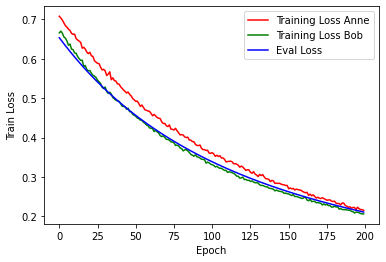

In [12]:
print(f"Anne Losses: {train_losses[0]}\n")
print(f"Bob Losses: {train_losses[1]}\n")
print(f"Test Losses: {test_losses}\n")
plt.plot(train_losses[0], 'r')
plt.plot(train_losses[1], 'g')
plt.plot(test_losses, 'b')
plt.legend(['Training Loss Anne', 'Training Loss Bob' , 'Eval Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

### Save First Model

In [13]:
# Save
PATH = "local_state_dict_model.pt"
torch.save(local_model.state_dict(), PATH)

### Prepare Test Data

In [14]:
data = pd.read_csv('test_sms_540.csv', sep=',', encoding= 'unicode_escape', names=['Teks', 'Label'])
# data = data.sample(frac = 1)
# Lowercase, remove unnecessary char with regex, remove stop words
data.Teks = data.Teks.apply(clean_text)
#     print(data.Teks)
words = set((' '.join(data.Teks)).split())
#     print(words)
word_to_idx = {word: i for i, word in enumerate(words, start=1)}
#     pprint(word_to_idx)
tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
#     print(tokens)
inputs = pad_and_truncate(tokens)
#     pprint(inputs)
labels = np.array((data.Label == '1').astype(int))

np.save('test_labels.npy', labels)
np.save('test_inputs.npy', inputs)

test_inputs = torch.tensor(np.load('test_inputs.npy'))
test_labels = torch.tensor(np.load('test_labels.npy'))


In [15]:
# Testing params
# VOCAB_SIZE = int(test_inputs.max()) + 1
TEST_VOCAB_SIZE = TRAIN_VOCAB_SIZE 
BATCH_SIZE = 30

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

### Load and Test First Model

Best Threshold=0.189229, G-Mean=0.540
Amount of test data: 540
ROC Accuracy Score: 0.5455197025578236

Accuracy Score: 0.5314814814814814


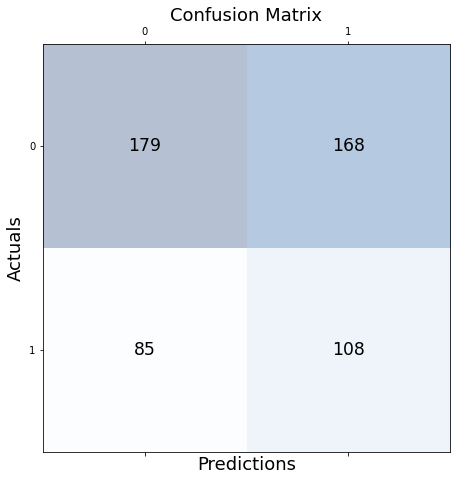


Confusion Matrix: 
[[179 168]
 [ 85 108]]

TN: 179	 FP: 168
FN: 85	 TP: 108

Precision: 0.391304347826087
Recall:0.5595854922279793
F1 Score: 0.46055437100213226


In [16]:
# Load First Model
PATH = "local_state_dict_model.pt"
load_model =    GRU(vocab_size=TEST_VOCAB_SIZE, 
                    hidden_dim=HIDDEN_DIM, 
                    embedding_dim=EMBEDDING_DIM, 
                    dropout=DROPOUT) 

load_model.load_state_dict(torch.load(PATH))
load_model.eval()

# Test Model

from sklearn.metrics import f1_score
criterion = nn.BCELoss()
# optimizer = optim.SGD(load_model.parameters(), lr=lr)

test_dataset = TensorDataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

test_losses = []

with torch.no_grad():
    test_preds = []
    test_labels_list = []
    eval_losses = []

    for i, (inputs, labels) in enumerate(test_loader):
        # print(f"i: {i}\nInputs: {inputs} Labels: {labels}")
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM)))

        output, _ = load_model(inputs.to(torch.long), h)
        loss = criterion(output.squeeze(), labels.float())
        eval_losses.append(loss)
        preds = output.squeeze()
        if len(labels) > 1:
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.numpy().astype(int))
        # print(f"Preds: {preds}\n Preds Type: {type(preds)}")


roc_acc_score = roc_auc_score(test_labels_list, test_preds)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# Index of largest G-means
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
threshold = thresholds[ix]

# Print how many data is being tested
print(f"Amount of test data: {len(test_labels_list)}")


# # Plot ROC Curve
# plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
# plt.plot(fpr, tpr, marker='.', label='Logistic')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend()
# # show the plot
# plt.show()

    
print(f"ROC Accuracy Score: {roc_acc_score}")

# Normalize probability with threshold
test_preds_thresholded = np.where(test_preds > threshold, 1, 0)
for i in range(len(test_preds)-1140):
    print("Test Preds Prob: {}    \
    Test Preds Label: {}  \
    True Label: {}  \
    ".format(test_preds[i], test_preds_thresholded[i], test_labels_list[i]))

acc_score = accuracy_score(test_labels_list, test_preds_thresholded)
print(f"\nAccuracy Score: {acc_score}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_labels_list, test_preds_thresholded)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print(f"\nConfusion Matrix: \n{cm}")

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]
print(f"\nTN: {tn}\t FP: {fp}\nFN: {fn}\t TP: {tp}\n")

# Precision
precision = tp/(tp+fp)
print(f"Precision: {precision}")

# Recall
recall = tp/(tp+fn)
print(f"Recall:{recall}")

# Calculate F1 Score
f1_score = f1_score(test_labels_list, test_preds_thresholded)
print(f"F1 Score: {f1_score}")

### Training Method #2

For now, PySyft does not support optimizers with momentum. Therefore, we are going to stick with the classical [Stochastic Gradient Descent](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) optimizer.

As our task consists of a binary classification, we are going to use the [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss).

In [17]:
# Defining loss and optimizer
second_model = make_model()
criterion = nn.BCELoss()
optimizer = optim.SGD(second_model.parameters(), lr=lr)

# Create data
# # Creating federated datasets, an extension of Pytorch TensorDataset class
federated_train_dataset = sy.FederatedDataset([bob_train_dataset, anne_train_dataset])
federated_test_dataset = sy.FederatedDataset([bob_test_dataset, anne_test_dataset])

# Creating federated dataloaders, an extension of Pytorch DataLoader class for TRAINIG METHOD #2
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, batch_size=BATCH_SIZE)
federated_test_loader = sy.FederatedDataLoader(federated_test_dataset, batch_size=BATCH_SIZE)

In [18]:
train_losses = []
test_losses = []

# For Early Stopping
last_loss = 100
patience = 3
trigger_times = 0


for e in range(EPOCHS):
    
    ######### Training ##########

    losses = []
    # Batch loop
    for inputs, labels in federated_train_loader:
        # Location of current batch
        worker = inputs.location
        # Initialize hidden state and send it to worker
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)
        # Send model to current worker
        second_model.send(worker)
        # Setting accumulated gradients to zero before backward step
        optimizer.zero_grad()
        # Output from the model
        output, _ = second_model(inputs.to(torch.long), h)
        # print(f"Output:{output}")
        # Calculate the loss and perform backprop
        # print(f"Output Shape: {output.shape} Labels Shape: {labels.shape}")
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # # Clipping the gradient to avoid explosion
        # nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        # Backpropagation step
        optimizer.step() 
        # Get the model back to the local worker
        second_model.get()
        losses.append(loss.get())
    
    
    ######## Evaluation ##########
    
    # Model in evaluation mode
    second_model.eval()

    with torch.no_grad():
        test_preds = []
        test_labels_list = []
        eval_losses = []

        for inputs, labels in federated_test_loader:
            # get current location
            worker = inputs.location
            # Initialize hidden state and send it to worker
            h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)    
            # Send model to worker
            second_model.send(worker)
            output, _ = second_model(inputs.to(torch.long), h)
            # loss = criterion(output.squeeze(), labels.float())
            loss = criterion(output, labels.float())
            eval_losses.append(loss.get())
            preds = output.squeeze().get()
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.get().numpy().astype(int))
            # Get the model back to the local worker
            second_model.get()

    # score = roc_auc_score(test_labels_list, test_preds)

    # Check test preds

    train_loss = sum(losses)/len(losses)
    eval_loss = sum(eval_losses)/len(eval_losses)
    
    train_losses.append(train_loss.item())
    test_losses.append(eval_loss.item())
    
    print("Epoch {}/{}...  \
    Training loss: {:.5f}...  \
    Validation loss: {:.5f}".format(e+1, EPOCHS, train_loss, eval_loss))
        
    # Early Stopping
    if eval_loss > last_loss:
        trigger_times += 1
        print(f"Trigger Times: {trigger_times}")
        
        if trigger_times >= patience:
            print("EARLY STOPPING! STARTING TEST PROCESS...")
            break
    else:
        print(f"Trigger Times: 0")
        trigger_times = 0
    
    last_loss = eval_loss
    
    second_model.train()

Epoch 1/200...      Training loss: 0.68900...      Validation loss: 0.67529
Trigger Times: 0
Epoch 2/200...      Training loss: 0.67209...      Validation loss: 0.66354
Trigger Times: 0
Epoch 3/200...      Training loss: 0.66555...      Validation loss: 0.65205
Trigger Times: 0
Epoch 4/200...      Training loss: 0.65809...      Validation loss: 0.64079
Trigger Times: 0
Epoch 5/200...      Training loss: 0.64276...      Validation loss: 0.62992
Trigger Times: 0
Epoch 6/200...      Training loss: 0.63125...      Validation loss: 0.61934
Trigger Times: 0
Epoch 7/200...      Training loss: 0.61843...      Validation loss: 0.60904
Trigger Times: 0
Epoch 8/200...      Training loss: 0.61178...      Validation loss: 0.59895
Trigger Times: 0
Epoch 9/200...      Training loss: 0.60100...      Validation loss: 0.58912
Trigger Times: 0
Epoch 10/200...      Training loss: 0.59388...      Validation loss: 0.57953
Trigger Times: 0
Epoch 11/200...      Training loss: 0.58145...      Validation loss: 

### Plot Training Method #2 Losses

Train Losses: [0.6889998316764832, 0.6720947623252869, 0.6655535697937012, 0.6580928564071655, 0.6427559852600098, 0.6312481164932251, 0.6184279322624207, 0.6117834448814392, 0.6010000109672546, 0.5938795804977417, 0.5814465880393982, 0.5697726607322693, 0.5608692765235901, 0.5525792837142944, 0.545518159866333, 0.5364646911621094, 0.5297957062721252, 0.5225861668586731, 0.5141797065734863, 0.5045021176338196, 0.4971862733364105, 0.49180158972740173, 0.4833100736141205, 0.4797002077102661, 0.4713115692138672, 0.4643292725086212, 0.4558200240135193, 0.45183444023132324, 0.44464194774627686, 0.4384668171405792, 0.432645708322525, 0.4253976345062256, 0.4204065799713135, 0.41340094804763794, 0.41017112135887146, 0.4042721390724182, 0.3989022374153137, 0.3936273753643036, 0.39322444796562195, 0.38461777567863464, 0.3781859874725342, 0.37391793727874756, 0.367418110370636, 0.36546599864959717, 0.3585582375526428, 0.3574621379375458, 0.35213351249694824, 0.35036250948905945, 0.343525797128677

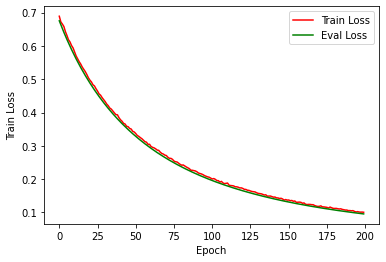

In [19]:
print(f"Train Losses: {train_losses}")
print(f"Test Losses: {test_losses}")
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'g')
plt.legend(['Train Loss', 'Eval Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

### Saving second model

In [20]:
# Save
PATH = "state_dict_model.pt"
torch.save(second_model.state_dict(), PATH)

In [21]:
# Testing params
VOCAB_SIZE = int(test_inputs.max()) + 1
TEST_VOCAB_SIZE = TRAIN_VOCAB_SIZE
BATCH_SIZE = 30

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

Best Threshold=0.088748, G-Mean=0.514
Amount of test data: 540


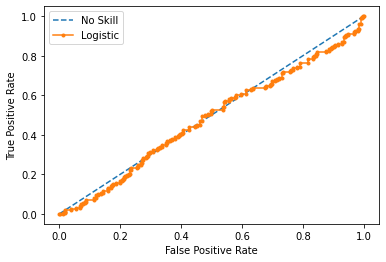

ROC Accuracy Score: 0.4815517164145675

Accuracy Score: 0.5166666666666667


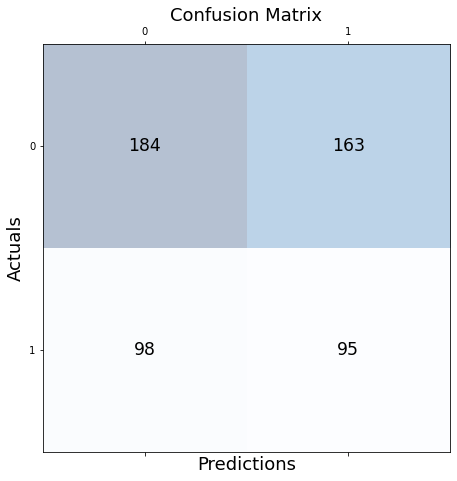


Confusion Matrix: 
[[184 163]
 [ 98  95]]

TN: 184	 FP: 163
FN: 98	 TP: 95

Precision: 0.3682170542635659
Recall:0.49222797927461137
F1 Score: 0.4212860310421286


In [22]:
# Load Second Model
PATH = "state_dict_model.pt"
load_model = GRU(vocab_size=TEST_VOCAB_SIZE, 
                hidden_dim=HIDDEN_DIM, 
                embedding_dim=EMBEDDING_DIM, 
                dropout=DROPOUT)
load_model.load_state_dict(torch.load(PATH))
load_model.eval()

# Test Model
from sklearn.metrics import f1_score
criterion = nn.BCELoss()
# optimizer = optim.SGD(second_model.parameters(), lr=lr)

test_dataset = TensorDataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

test_losses = []

with torch.no_grad():
    test_preds = []
    test_labels_list = []
    eval_losses = []

    for inputs, labels in test_loader:
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM)))
        output, _ = second_model(inputs.to(torch.long), h)
        # print(f"Output Shape:{output.shape}")
        loss = criterion(output.squeeze(), labels.float())
        eval_losses.append(loss)
        preds = output.squeeze()
        if len(labels) > 1:
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.numpy().astype(int))


roc_acc_score = roc_auc_score(test_labels_list, test_preds)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# Index of largest G-means
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
threshold = thresholds[ix]

# Print how many data is being tested
print(f"Amount of test data: {len(test_labels_list)}")


# Plot ROC Curve
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

    
print(f"ROC Accuracy Score: {roc_acc_score}")

# Normalize probability with threshold
test_preds_thresholded = np.where(test_preds > threshold, 1, 0)
for i in range(len(test_preds)-1140):
    print("Test Preds Prob: {}    \
    Test Preds Label: {}  \
    True Label: {}  \
    ".format(test_preds[i], test_preds_thresholded[i], test_labels_list[i]))

acc_score = accuracy_score(test_labels_list, test_preds_thresholded)
print(f"\nAccuracy Score: {acc_score}")


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels_list, test_preds_thresholded)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print(f"\nConfusion Matrix: \n{cm}")

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]
print(f"\nTN: {tn}\t FP: {fp}\nFN: {fn}\t TP: {tp}\n")

# Precision
precision = tp/(tp+fp)
print(f"Precision: {precision}")

# Recall
recall = tp/(tp+fn)
print(f"Recall:{recall}")

# Calculate F1 Score
f1_score = f1_score(test_labels_list, test_preds_thresholded)
print(f"F1 Score: {f1_score}")

### Inference

In [118]:

model_threshold = threshold

# Load Second Model
infer_model = GRU(vocab_size=4281, 
                hidden_dim=10, 
                embedding_dim=50, 
                dropout=0.2)
infer_model.load_state_dict(torch.load("state_dict_model.pt"))
infer_model.eval()

sentence = input()

def pre_process(text):
    text = clean_text(text)
    print(f"Text: {text}\n")

    words = text.split()
    print(f"Words: {words}\n")

    token = lambda x: tokenize (x, word_to_idx)
    token_result = token(text)
    print(f"Tokenization Result: {token_result}")

    arr = []
    arr.append(token_result)
    inputs = pad_and_truncate(arr)
    print(inputs)

    input = torch.tensor(inputs)
    print(input)
    return input

with torch.no_grad():
    infer_sentence = pre_process(sentence)
    print(f"Infer Sentence: {infer_sentence}")
    h = torch.Tensor(np.zeros((1, 10)))

    output, _ = infer_model(infer_sentence.to(torch.long), h)
    print(f"\nOutput: {output.squeeze()}")

    if output > model_threshold:
        print("Sentence is a Scam")
    else:
        print("Sentence is NOT a Scam")




Text: selamat no terdaftar meraih cek juta pinwha info klik bitlywhatsappjkt

Words: ['selamat', 'no', 'terdaftar', 'meraih', 'cek', 'juta', 'pinwha', 'info', 'klik', 'bitlywhatsappjkt']

Tokenization Result: [933, 3772, 823, 4197, 2982, 408, 3728, 1319, 2912, 1373]
('Messages: [[933, 3772, 823, 4197, 2982, 408, 3728, 1319, 2912, 1373]]\n'
 'Features: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]')
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  933 3772  823 4197 2982  408 3728 1319
  2912 1373]]
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  933, 3772,  823, 4197,
         2982,  408, 3728, 1319, 2912, 1373]], dtype=torch.int32)
Infer Sentence: tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  933, 3772,  823, 4197,
         2982,  